In [53]:
import os
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
#set directory to ZippedData
os.chdir(r"zippedData")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'zippedData'

In [54]:
#load files
movie_budget=pd.read_csv("tn.movie_budgets.csv.gz") #budget and gross revenue of movies
spy_monthly=pd.read_csv("SPY.csv") #stock market monthly returns
GDP=pd.read_csv('GDP_DEF.csv') #GDP deflator to adjust numbers by inflation

In [3]:
#dealing with dates and trim off 2019
movie_budget.rename(columns={"movie":"title"}, inplace=True)
movie_budget['release_date']=pd.to_datetime(movie_budget['release_date'])
movie_budget['view_date']=movie_budget.release_date+pd.offsets.MonthBegin(1)
movie_budget['year']=movie_budget['view_date'].dt.year
movie_budget=movie_budget[movie_budget['year']<=2018]

In [4]:
#spy_monthly contains dates only beyond 2000, by default the merged file has a time frame between 2000 to 2018
spy_monthly['view_date']=pd.to_datetime(spy_monthly['Date'])
spy_monthly.sort_values(["view_date"],inplace=True)
spy_monthly['percent_return_month']=(spy_monthly['Adj Close'].shift(-1)-spy_monthly['Adj Close'])/spy_monthly['Adj Close']*100
spy_monthly['percent_return_rolling']=spy_monthly.percent_return_month.rolling(2).mean()
spy_monthly['market_condition']=pd.cut(spy_monthly['percent_return_rolling'], bins=3, labels=['Low','Medium','High'])
movie_budget=movie_budget.merge(spy_monthly[['view_date','percent_return_month','percent_return_rolling',"market_condition"]], on="view_date")
movie_budget=movie_budget.merge(GDP, on='year')

In [5]:
to_replace_list=["domestic_gross","worldwide_gross","production_budget"]
for i in to_replace_list:
    movie_budget[i]=movie_budget[i].str.replace(r"$","")
    movie_budget[i]=movie_budget[i].str.replace(r",","")

In [6]:
for i in to_replace_list:
    movie_budget[i]=movie_budget[i].astype("int64")/movie_budget['nondurable_goods_expenditure']*100

In [7]:
movie_budget['domestic_profit']=(movie_budget['domestic_gross']-movie_budget['production_budget'])
movie_budget['foreign_profit']=(movie_budget['worldwide_gross']-movie_budget['domestic_gross'])
movie_budget['profit_margin']=(movie_budget['worldwide_gross']-movie_budget['production_budget'])/(movie_budget['production_budget'])*100
movie_budget['domestic_margin']=(movie_budget['domestic_profit'])/(movie_budget['production_budget'])*100
movie_budget['foreign_margin']=(movie_budget['foreign_profit'])/(movie_budget['production_budget'])*100

In [18]:
movie_budget['production_budget_rank']=movie_budget.groupby(['year'])['production_budget'].rank(pct=True)
movie_budget['budget_size']=pd.cut(movie_budget['production_budget_rank'], bins=2, labels=["Independent","Mass Production"])
movie_budget['count']=movie_budget.groupby(['view_date'])['title'].transform("count")
movie_budget['competition_size']=pd.cut(movie_budget['count'], bins=4, \
                                   labels=['Low','Moderately Low','Moderately High','High'])

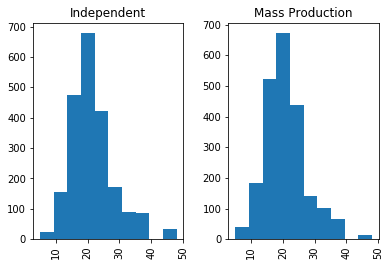

In [52]:
movie_budget.hist('count',by="budget_size")
movie_budget.to_pickle(r"..//merged_file.pickle")

<Figure size 432x288 with 0 Axes>

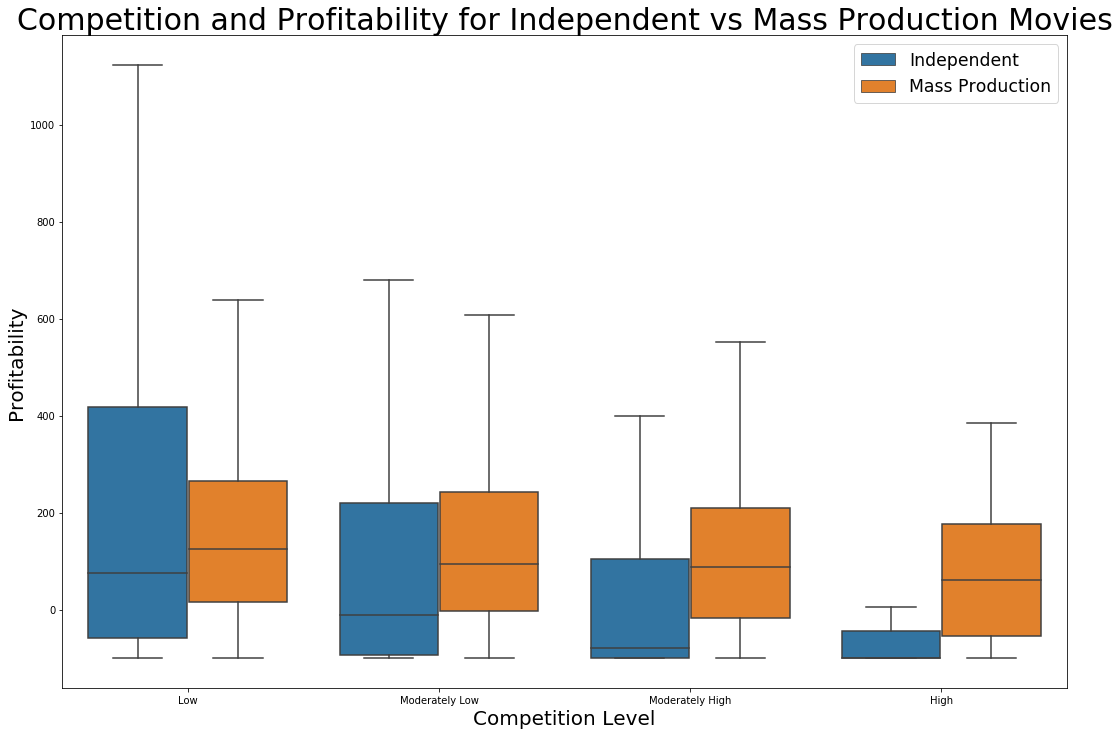

In [21]:
plt.clf()
plt.figure(figsize=(18, 12))
sns.boxplot('competition_size','profit_margin', data=movie_budget, hue="budget_size", showfliers=False)
plt.xlabel("Competition Level", size=20)
plt.ylabel("Profitability", size=20)
plt.legend(fontsize="xx-large")
plt.title("Competition and Profitability for Independent vs Mass Production Movies", size=30)
plt.savefig("..\\competition and profitability.png")

<Figure size 432x288 with 0 Axes>

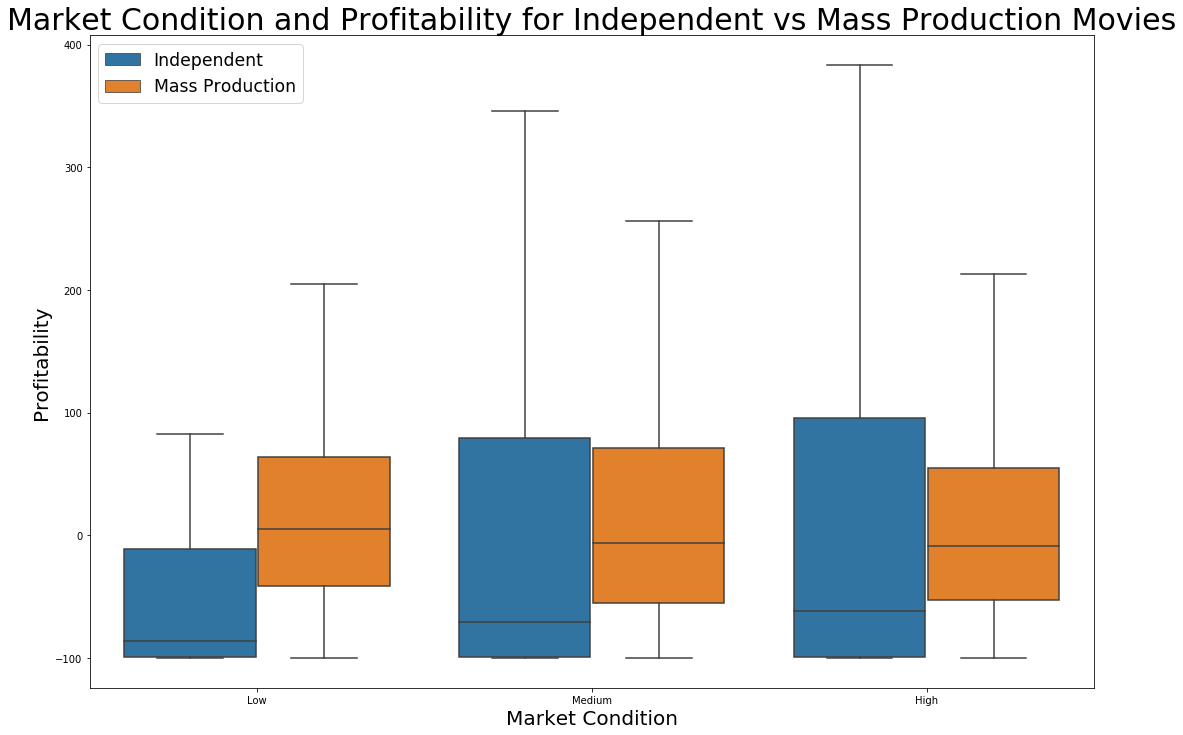

In [22]:
plt.clf()
plt.figure(figsize=(18, 12))
sns.boxplot('market_condition','domestic_margin', data=movie_budget, hue="budget_size", showfliers=False)
plt.xlabel("Market Condition", size=20)
plt.ylabel("Profitability", size=20)
plt.legend(fontsize="xx-large")
plt.title("Market Condition and Profitability for Independent vs Mass Production Movies", size=30)
plt.savefig("..\\Market and profitability.png")

In [48]:
movie_budget['month']=movie_budget.view_date.dt.strftime("%B")
movie_budget['month_num']=movie_budget.view_date.dt.month
movie_budget_agg=movie_budget.groupby("month").\
        agg({"title":"count","profit_margin":"mean","month_num":"min"}).reset_index()
movie_budget_agg=movie_budget_agg.sort_values("month_num")

In [49]:
movie_budget_agg

,month,title,profit_margin,month_num
4,January,555,130.503434,1
3,February,253,236.152903,2
7,March,298,210.236444,3
0,April,368,172.636639,4
8,May,363,210.179087,5
6,June,289,375.341870,6
5,July,324,255.241078,7
1,August,320,365.442386,8
11,September,368,238.897889,9
10,October,396,281.375026,10


<Figure size 432x288 with 0 Axes>

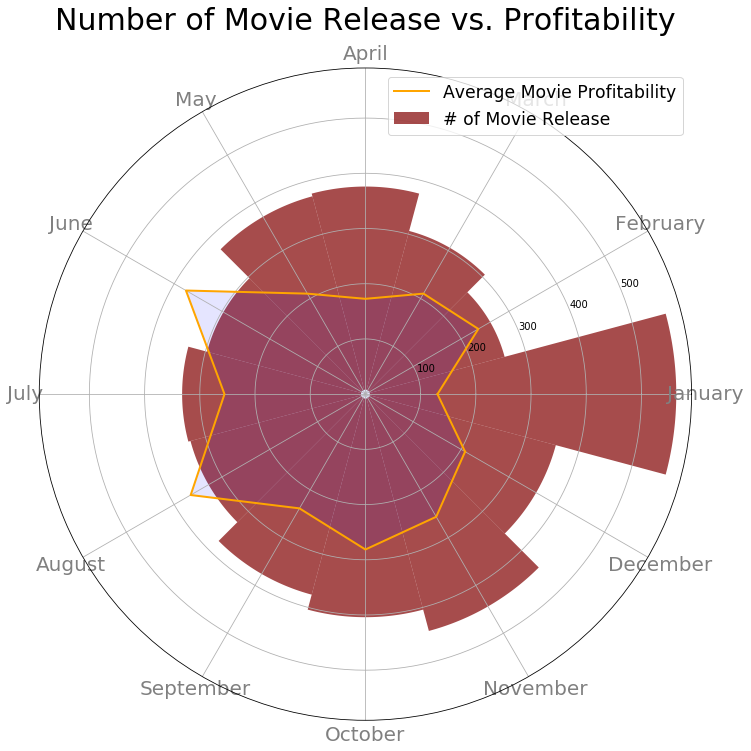

In [50]:
plt.clf()
plt.figure(figsize=(18,12))
bottom = 8
max_height = 4
N=12
theta = [n / float(N) * 2 * pi for n in range(N)]
width = (2*pi) / N

radii=movie_budget_agg["title"].to_list()
radiii=movie_budget_agg["profit_margin"].to_list()
ax = plt.subplot(111, polar=True)

bars = ax.bar(theta, radii, width=width, bottom=bottom, label='# of Movie Release')
ax.plot(theta, radiii, linewidth=2, linestyle='solid',color="orange", label='Average Movie Profitability')
ax.plot([theta[-1],theta[0]], [radiii[-1],radiii[0]], linewidth=2, linestyle='solid', color="orange")
plt.xticks(theta, movie_budget_agg["month"], color='grey', size=20)
plt.fill(theta, radiii, 'b', alpha=0.1)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.7)

ax.legend(fontsize="xx-large")
plt.title("Number of Movie Release vs. Profitability", size=30)
plt.savefig("..//release_profitability_month.png")